In [33]:
import pandas as pd
import pandas_profiling

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb


#データ読み込み
train = pd.read_csv("data/train_df.csv")
test = pd.read_csv("data/test_df.csv")
sample= pd.read_csv("data/submission.csv",header = None)

In [34]:
ids = ['id', 'personal_id_1', 'personal_id_2',]
cats = ['facility_id', 'icu_5', 'icu_7', 'icu_8', 'icu_id', 'situation_1', 'situation_2', 'glasgow_coma_scale_3', 'blood_oxy']
dis_name = ['aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma'] 
for c in ids:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)

for c in cats:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)
    
for c in dis_name:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)
    
# 数値データ
y_train=train[['target_label']]
x_train=train.drop('target_label',axis=1)
col_num = x_train.columns[x_train.dtypes!='object'].values.tolist()
print('数値データ')
print(col_num)
print('-'*100)
col_cat = x_train.columns[x_train.dtypes=='object'].values.tolist()
print('カテゴリ変数')
print(col_cat)




数値データ
['age', 'bmi', 'height', 'weight', 'icu_4', 'icu_6', 'glasgow_coma_scale_1', 'glasgow_coma_scale_2', 'glasgow_coma_scale_4', 'heart_rate', 'arterial_pressure', 'respiratory_rate', 'temp', 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4', 'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
----------------------------------------------------------------------------------------------------
カテゴリ変数
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'situation_1', 'situation_2', 'ethnicity', 'gender', 'icu_id', 'icu_1', 'icu_2', 'icu_3', 'icu_5', 'icu_7', 'icu_8', 'glasgow_coma_scale_3', 'blood_oxy', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma', 'body_system_1', 'body_system_

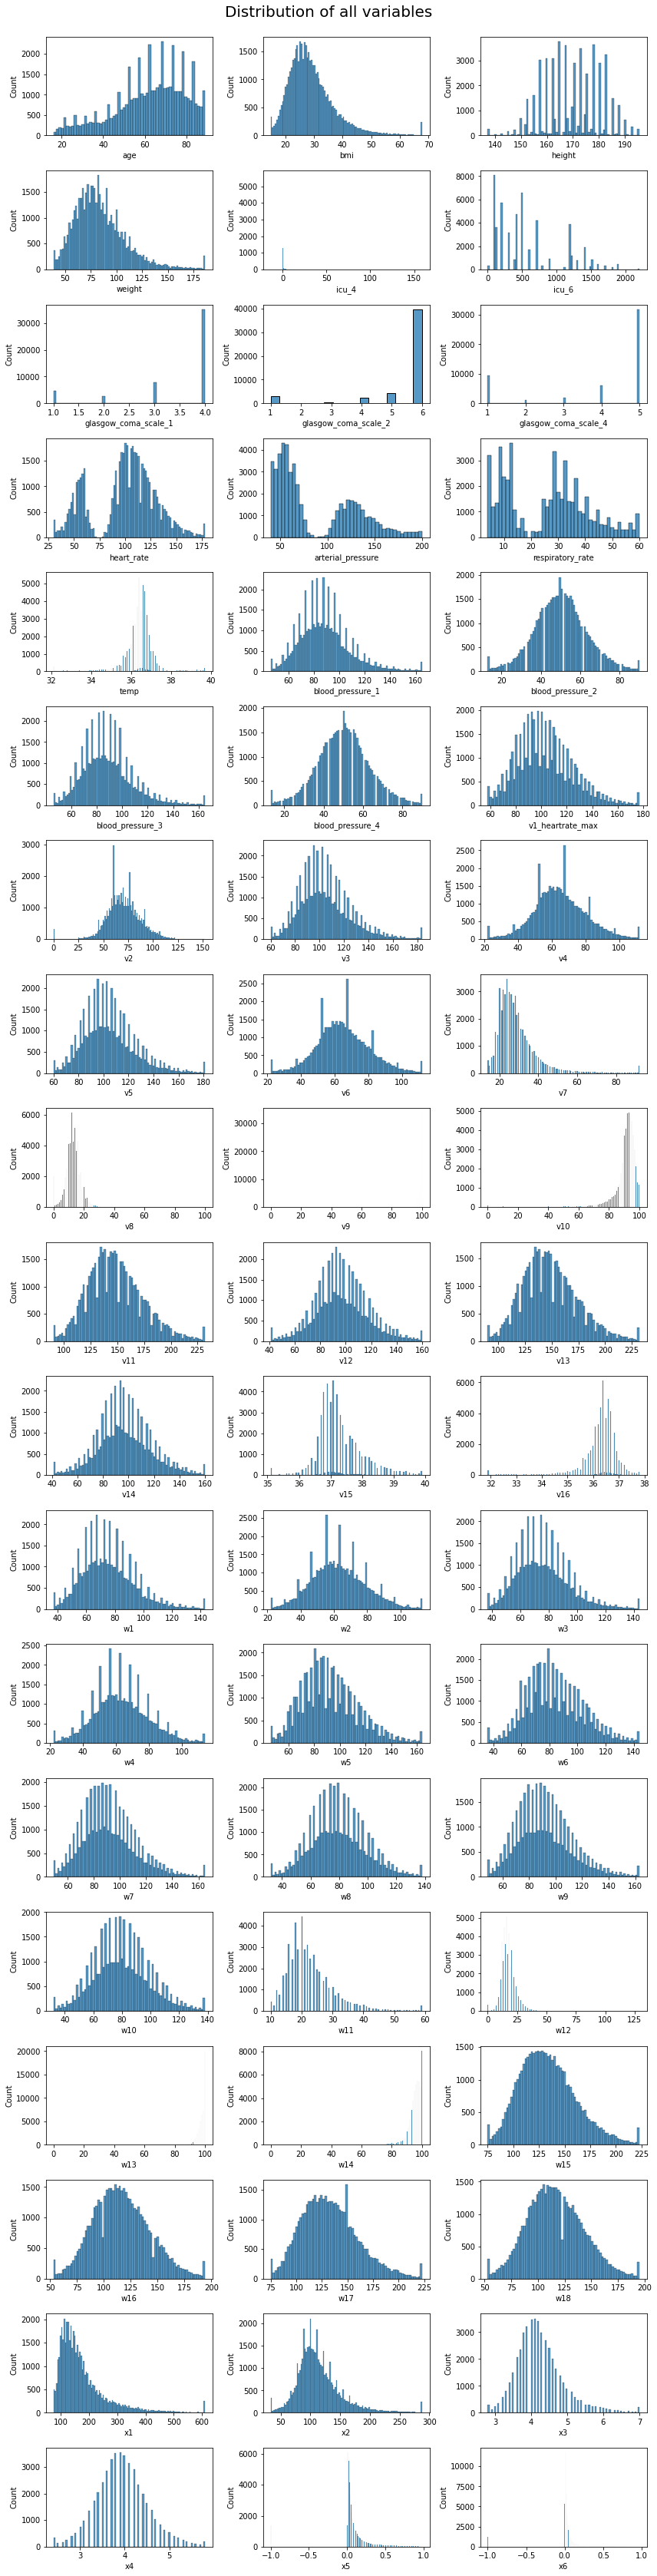

In [35]:
ncols = 3
nrows = np.ceil(len(col_num)/ncols).astype(int)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,nrows*2.5))
for c, ax in zip(col_num, axs.flatten()):
    sns.histplot(train, x=c, ax=ax)
fig.suptitle('Distribution of all variables', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])

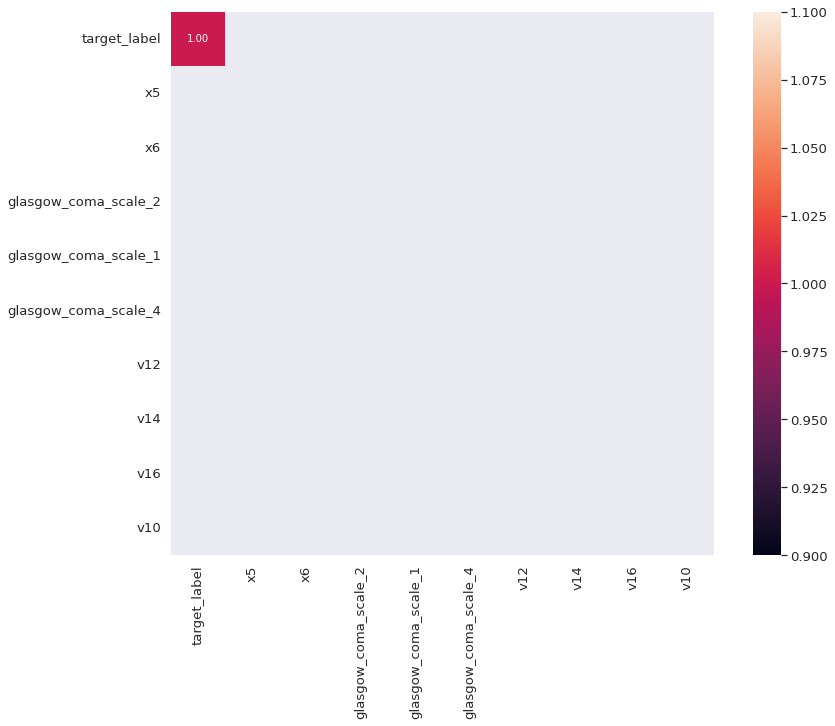

In [42]:
TARGET = "target_label"
k = 10 # number of variables for heatmap
corrmat = train.corr()
corrmat = np.abs(corrmat)
cols = corrmat.nlargest(k, TARGET)[TARGET].index
cm = np.corrcoef(train[cols].values.T)
fig, ax = plt.subplots(figsize=(14, 10))
# sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}, yticklabels=cols.values, xticklabels=cols.values)